TF version: 2.13.1
Train size: 25000
Test size: 25000
First review (indices): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447]
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was a

2025-11-11 12:02:56.321825: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.


625/625 [==============================] - 34s 52ms/step - loss: 0.5123 - accuracy: 0.7685 - val_loss: 0.3313 - val_accuracy: 0.8734
Epoch 2/10
625/625 [==============================] - 33s 54ms/step - loss: 0.2676 - accuracy: 0.8988 - val_loss: 0.2849 - val_accuracy: 0.8886
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.2068 - accuracy: 0.9228 - val_loss: 0.2922 - val_accuracy: 0.8902
Epoch 4/10
625/625 [==============================] - 34s 55ms/step - loss: 0.1677 - accuracy: 0.9398 - val_loss: 0.2870 - val_accuracy: 0.8940
Epoch 5/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1402 - accuracy: 0.9502 - val_loss: 0.3017 - val_accuracy: 0.8960
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1193 - accuracy: 0.9599 - val_loss: 0.3303 - val_accuracy: 0.8902
Epoch 7/10
625/625 [==============================] - 34s 54ms/step - loss: 0.1001 - accuracy: 0.9686 - val_loss: 0.3492 - val_accuracy: 0.8904
Epo

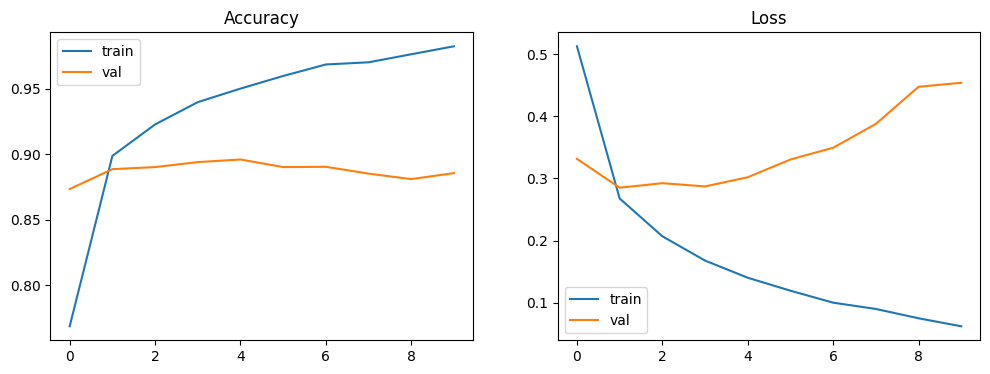

  8/782 [..............................] - ETA: 6s - loss: 0.3828 - accuracy: 0.8789 

2025-11-11 12:08:34.358356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50000000 exceeds 10% of free system memory.


782/782 [==============================] - 7s 9ms/step - loss: 0.5100 - accuracy: 0.8630
Test accuracy: 0.8629599809646606
Embeddings shape: (10001, 100)
Saved vecs.tsv and meta.tsv (can upload to projector.tensorflow.org)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, preprocessing
import numpy as np
import matplotlib.pyplot as plt

print("TF version:", tf.__version__)

# Keep top 10k words (as lab suggests)
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = datasets.imdb.load_data(num_words=num_words)

print("Train size:", len(train_data))
print("Test size:", len(test_data))
print("First review (indices):", train_data[0][:50])

word_index = datasets.imdb.get_word_index()
reverse_word_index = {value+3: key for key, value in word_index.items()}
# reserve 0,1,2 indices for padding/special tokens as Keras uses
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"

decoded = ' '.join([reverse_word_index.get(i, '?') for i in train_data[0]])
print(decoded[:800])  # print first ~800 chars

maxlen = 500   # or 250 to speed up / reduce memory
train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post')
test_data  = preprocessing.sequence.pad_sequences(test_data,  maxlen=maxlen, padding='post', truncating='post')

print("Padded train shape:", train_data.shape)

embedding_dim = 100   # or 50 if you want smaller/faster
vocab_size = num_words + 1

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data, train_labels,
    epochs=10,           # try 5 first, then 10
    batch_size=32,       # try 64 to use less memory
    validation_split=0.2
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test accuracy:", test_acc)

embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]  # shape (vocab_size, embedding_dim)
print("Embeddings shape:", embeddings.shape)

# Save vectors + metadata for projector use
import io, os
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for i in range(1, vocab_size):   # skip 0 if you like
    word = reverse_word_index.get(i, "<UNK>")
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings[i]]) + "\n")
out_v.close()
out_m.close()
print("Saved vecs.tsv and meta.tsv (can upload to projector.tensorflow.org)")
